$\begin{align}
	&u_t + c(x)u_x = 0, \text{ em } [0,5] \times [0,6.4], \\
	&u(x,0) = f(x), \\~\\
	&c(x) = 1/5+\sin(x-1)^2, \\
	&f(x) = e^{-100(x-1)^2}
\end{align}$

In [18]:
using Pkg; Pkg.activate(".");

  Activating new project at `c:\Users\gozan\.vscode\Julia\SHOPDEPINN\Poster`


In [19]:
using NeuralPDE, Lux, Random, Optimization, OptimizationOptimisers, ModelingToolkit, Zygote, Plots
import ModelingToolkit: Interval
import Optimization: OptimizationFunction, OptimizationProblem, solve
Random.seed!(0);

In [20]:
xmin = 0; xmax = 5; tmin = 0; tmax = 6.4
c(x) = 1/5+sin(x-1)^2
f(x) = exp(-100(x-1)^2)
aux(x,t) = ((t-2.0491*x) <= 1.4279) * ((t-2.0194*x) >= -4.9414)
u_exata(x,t) = exp(-100*(atan((1/sqrt(6))*tan(atan(sqrt(6)*tan(x-1))-(sqrt(6)/5)*t)))^2);

In [21]:
Neurons = 1
Layers = 1

N_D = 1
N_I = 1;

In [22]:
@parameters x t
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)

PDE = [Dt(u(x,t)) + c(x)*Dx(u(x,t)) ~ 0]
IC = [u(x, 0) ~ f(x)]

Ω = [x ∈ Interval(xmin, xmax), t ∈ Interval(tmin, tmax)];

In [23]:
Lux_NN = Chain(    
	Dense(2, Neurons, Lux.tanh; 
	init_weight = Lux.glorot_uniform, init_bias = Lux.glorot_uniform),

    [Dense(Neurons, Neurons, Lux.tanh; 
	init_weight = Lux.glorot_uniform, init_bias = Lux.glorot_uniform) for i in 1:1:Layers],

    Dense(Neurons, 1; 
	init_weight = Lux.glorot_uniform, init_bias = Lux.glorot_uniform))

Weight_NN = Lux.setup(Random.default_rng(0), Lux_NN)[1];

In [24]:
Strategy = FixedStochasticTraining(N_D, N_I) 

Discretization = PhysicsInformedNN(Lux_NN, Strategy, init_params = Weight_NN)

@named PDE_System = PDESystem(PDE, IC, Ω, [x, t], u(x, t))

Problem_NeuralPDE = symbolic_discretize(PDE_System, Discretization);

Weight_NN = PINN_problem.flat_init_params

pde_loss_functions = PINN_problem.loss_functions.pde_loss_functions
bc_loss_functions = PINN_problem.loss_functions.bc_loss_functions;

In [25]:
function loss(θ, p)
    return sum(map(l -> l(θ), [pde_loss_functions; bc_loss_functions]))
end
function callback(p, l)
	if p.iter%1 == 0
		println("iteration: ", p.iter)
		println("loss_PINN: ", l)
		println("loss_PDE: ", map(l_ -> l_(p.u), pde_loss_functions)[1])
		println("loss_IC: ", map(l_ -> l_(p.u), bc_loss_functions)[1])
	end
	return false
end

Optimization_Function = OptimizationFunction(loss, AutoZygote())
Epoch = 3
Optimization_Problem = OptimizationProblem(Optimization_Function, Weight_NN) 
result = solve(Optimization_Problem, ADAM(10^-3); callback = callback, maxiters = Epoch)
Weight_NN = result.u;

iteration: 1
loss_PINN: 0.4725280442963263
loss_PDE: 7.814557653869528e-5
loss_IC: 0.4724499
iteration: 2
loss_PINN: 0.46885677765138184
loss_PDE: 7.906149156129088e-5
loss_IC: 0.46877772
iteration: 3
loss_PINN: 0.46520304757395065
loss_PDE: 7.972198763169931e-5
loss_IC: 0.46512333
iteration: 3
loss_PINN: 0.46520304757395065
loss_PDE: 7.972198763169931e-5
loss_IC: 0.46512333


In [26]:
PINN(x,t) = Problem_NeuralPDE.phi([x,t], Weight_NN)[1];

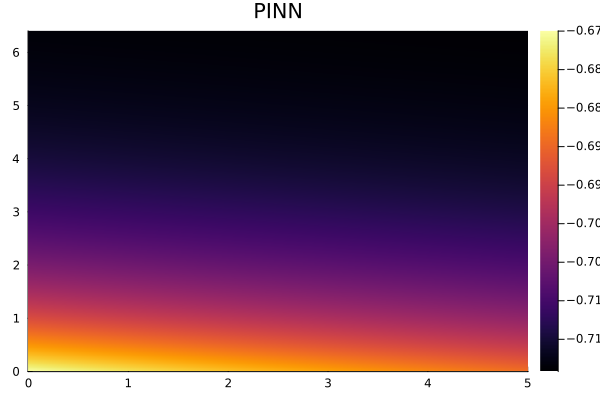

In [28]:
Δx = 0.01; x = xmin:Δx:xmax
Δt = Δx/1.2; t = tmin:Δt:tmax
u_PINN = [PINN(i, j) for j in t, i in x]
heatmap(x, t, u_PINN, title="PINN")